In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

In [ ]:
from sklearn.utils import shuffle

In [ ]:
from scipy import stats

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D  
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, LeakyReLU
from tensorflow.keras.initializers import Constant

In [ ]:
def min_max_scale(train_df,val_df,test_df):
    train_min = np.min(train_df,axis=0)
    train_max = np.max(train_df,axis=0)

    train_df = (train_df - train_min)/(train_max - train_min)
    val_df = (val_df - train_min) /(train_max - train_min)
    test_df = (test_df - train_min) /(train_max - train_min)

    return(train_df,val_df,test_df)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time",fontsize=25)
    plt.ylabel("Value (mm)",fontsize=25)    
    plt.yticks(fontsize=16) 
    plt.xticks(fontsize=16)
    plt.grid(True)

In [ ]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth ):
    plt.figure(figsize=(20, 4))


    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    
    plt.plot(np.arange(range_history), np.array(history),
             'skyblue',marker='o',markersize=5,
             label='History')
    
    plt.plot(range_future, np.array(prediction1),
             'orangered',marker='o',markersize=5,#alpha=.4,
             linestyle='dashed',
             label='Forecasted with 2D-CNN')
    
    plt.plot(range_future, np.array(groundtruth), 
             'blue',marker='o',markersize=5,#alpha=.4,
             linestyle='dashed',
             label='Real')
    
    plt.legend(loc='upper left')
    #plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Value (mm)' , fontsize=18)
  

In [ ]:
#path = '/home/juan/Desktop/TESIS/Codes/codesTesis/Paso1/'
path = '/content/'
Dataset = pd.read_csv(path+'Rumipamba.csv',index_col=0)
Dataset

,Value (%),Value (hPa),Value (W/m2),Value (°C),Value (mm),Monthly sin,Monthly cos,Bi-monthly sin,Bi-monthly cos,Wind X,Wind Y
Fecha,,,,,,,,,,,
2019/08/16 14:20:00,38.0,685.5,128.000000,12.7,0.0,0.844951,0.534844,0.482263,0.876026,0.038162,0.196325
2019/08/16 14:25:00,39.0,685.5,99.000000,12.7,0.0,0.845340,0.534229,0.482582,0.875851,0.061803,0.190211
2019/08/16 14:30:00,42.0,685.5,94.000000,12.7,0.0,0.845728,0.533615,0.482900,0.875675,-0.307818,0.845723
2019/08/16 14:35:00,42.0,685.5,117.000000,12.6,0.0,0.846116,0.532999,0.483219,0.875500,-0.782870,1.160653
2019/08/16 14:40:00,42.0,685.5,110.666667,12.3,0.0,0.846503,0.532384,0.483537,0.875324,-1.271276,2.606503
...,...,...,...,...,...,...,...,...,...,...,...
2020/04/14 11:15:00,84.0,687.0,409.000000,11.7,0.0,0.985184,0.171499,0.643623,0.765343,-0.459627,0.385673
2020/04/14 11:20:00,87.0,686.9,854.000000,12.6,0.0,0.985309,0.170783,0.643901,0.765109,0.262424,-0.301884
2020/04/14 11:25:00,79.0,686.9,250.000000,13.0,0.0,0.985433,0.170066,0.644179,0.764875,-0.337146,0.834465


Transfor this to a time series forecasting as:


X = [1:576] $\rightarrow$ Y = [576:584]

In [ ]:
Data = Dataset.copy()
Data = Data.to_numpy()

label = Dataset["Value (mm)"].copy()
label = label.to_numpy()

In [ ]:
"""aa= [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
sm=[]
x=[]
for i in range(len(aa)-3-1):
  x.append(aa[i:i+3])
  sm.append(sum(aa[i+3:i+3+2]))
  print("x=",x[-1],"sum",aa[i+3:i+3+2],"igual",sm[-1])"""

'aa= [1,2,3,4,5,6,7,8,9,10,11,12,13,14]\nsm=[]\nx=[]\nfor i in range(len(aa)-3-1):\n  x.append(aa[i:i+3])\n  sm.append(sum(aa[i+3:i+3+2]))\n  print("x=",x[-1],"sum",aa[i+3:i+3+2],"igual",sm[-1])'

In [ ]:
X = []
y=[]
prev_values=[]

for i in range(0,len(Data)-37-1):
  X.append(Data[i:i+36])                # cada elemento de X es una mat de 36x11 (36 = 3 horas)
  y.append(sum(label[i+36:i+36+6]))     # 'y' tiene la suma de 6 valores futuros
  
#  for j in range(7):
#    s = sum(label[i+30+j:i+30+j+6])
#    prev_values.append(s)               # los valores previos a 'y' (para el plot)

In [ ]:
print("Hay",len(X), "elementos en X")
print("Cada elemento de X tiene ",X[-1].shape)
print("O sea (",len(X),",",X[-1].shape,")")

print("\nHay",len(y), "elementos en y")
print("Cada elemento de y tiene tamano",y[-1].shape)

#print("\nHay",len(prev_values), "elementos en prev_values")
#print("Cada elemento de prev_values tiene tamano",prev_values[-1].shape)

Hay 68170 elementos en X
Cada elemento de X tiene  (36, 11)
O sea ( 68170 , (36, 11) )

Hay 68170 elementos en y
Cada elemento de y tiene tamano ()


**Reshape the feature matrix to be convolutional and time distributed ready as:** 


# X = [samples], [frames], [width], [length], [channel]

# X =  [samples], [windows], [timesteps], [features], [stations]


In [ ]:
conv_X = np.zeros((len(X),3,12,11))                     # separamos cada 
i=0                                                     # elemento de X
                                                        # en 3 frames de 
for mat in X:                                           # 12 timestep x 11 features
  xx = np.zeros((3,12,11))
  xx[0] = np.asarray(mat[0:12])          
  xx[1] = np.asarray(mat[12:24])    
  xx[2] = np.asarray(mat[24:])
  conv_X[i] = xx
  i+=1

conv_X.shape

(68170, 3, 12, 11)

In [ ]:
conv_X = conv_X.reshape(conv_X.shape[0],3,12,11, 1).astype('float32')

Split, scale and shuffle the data

In [ ]:
n = len(conv_X)
X_train = np.asanyarray(conv_X[0:int(n*0.7)])
X_val = np.asanyarray(conv_X[int(n*0.7):int(n*0.9)])
X_test = np.asanyarray(conv_X[int(n*0.9):])

X_train,X_val,X_test = min_max_scale(X_train,X_val,X_test)

Y_train = np.asanyarray(y[0:int(n*0.7)])
Y_val = np.asanyarray(y[int(n*0.7):int(n*0.9)])
Y_test = np.asanyarray(y[int(n*0.9):])

#prev_values = np.asarray(prev_values[int(n*0.9):])


In [ ]:
X_train, Y_train = shuffle(X_train,Y_train)
X_val, Y_val = shuffle(X_val,Y_val)

In [ ]:
X_train.shape

(47719, 3, 12, 11, 1)

In [ ]:
def convolutional_model():
    model = Sequential()

    #model.add(tf.keras.layers.Lambda(lambda x:x*100))

    # extract features:
    # Conv layers learns of 32-64-128 filters, each
		# Of which are 1x1 or 3x3
    # then apply 2x2 strides to reduce
		# the spatial dimensions of the volume

    # Note how the output spatial volume is decreasing
    # while number of filters learned is increasing
   

    model.add(TimeDistributed(
        Conv2D(filters = 32, kernel_size=(3, 3),
               strides=(1, 1), padding='same',
               activation='relu',
               input_shape=(12, 11, 1))))

    model.add(TimeDistributed(
        Conv2D(filters = 64, kernel_size=(3, 3),
               strides=(1, 1), padding='same',
               activation='relu')))

#    model.add(TimeDistributed(
#        Conv2D(filters = 128, kernel_size = (3, 3), 
#               strides=(2, 2), padding="valid",
#               activation = LeakyReLU(alpha=-2))))    


    model.add(TimeDistributed(
        MaxPooling2D(pool_size=(2, 2),
                     strides=(1, 1), 
                     padding='same')))
    

    
    # input to LSTM & NN
    model.add(TimeDistributed(Flatten()))  


    #Many-to-one implies return_sequence = False
    #model.add(LSTM(64, activation=tf.keras.layers.LeakyReLU(alpha=-2),
                   #return_sequences=False,
                   #kernel_initializer=tf.keras.initializers.Constant(5)))

        
    model.add(Flatten())
    #model.add(tf.keras.layers.BatchNormalization())
   
    #model.add(Dropout(0.5))    
    
    #output
    
    model.add(Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=-2),
                    kernel_initializer = Constant(5)))
    
    

    model.add(Dense(units=4, activation=tf.keras.layers.ELU(alpha=0.01),
                    kernel_initializer = Constant(10)))

    model.add(Dense(units=1))
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

model = convolutional_model()

In [ ]:
#This is the last, makes flat lines and high peaks
# but has a weird offset 

"""def convolutional_model():
    model = Sequential()

    #model.add(tf.keras.layers.Lambda(lambda x:x*100))

    # extract features:
    # Conv layers learns of 32-64-128 filters, each
		# Of which are 1x1 or 3x3
    # then apply 2x2 strides to reduce
		# the spatial dimensions of the volume

    # Note how the output spatial volume is decreasing
    # while number of filters learned is increasing


    model.add(TimeDistributed(
        Conv2D(filters = 32, kernel_size=(3, 3),
               strides=(1, 1),
               activation='relu',
               input_shape=(24, 11, 1))))

    model.add(TimeDistributed(
        Conv2D(filters = 64, kernel_size=(1, 1),
                              strides=(1, 1),
                              activation='relu')))

#    model.add(TimeDistributed(
#        Conv2D(filters = 128, kernel_size = (3, 3), 
#               strides=(2, 2), padding="valid",
#               activation = LeakyReLU(alpha=-2))))    



    # Pool Max values
    #model.add(TimeDistributed( 
    #    GlobalMaxPooling2D()))
    
    #model.add(Dropout(0.5))

    # input to LSTM & NN
    model.add(TimeDistributed(Flatten()))

    #model.add(LSTM(64, activation=tf.keras.layers.LeakyReLU(alpha=-2),
                   #return_sequences=True,
                   #kernel_initializer=tf.keras.initializers.Constant(5)))


    
    model.add(Flatten())
    #model.add(tf.keras.layers.BatchNormalization())
   
    #model.add(Dropout(0.5))    
    
    #output
    
    model.add(Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=-2),
                    kernel_initializer = Constant(5)))
    
    

    model.add(Dense(units=4, activation=tf.keras.layers.ELU(alpha=0.01),
                    kernel_initializer = Constant(10)))

    model.add(Dense(units=1))
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

model = convolutional_model()"""

'def convolutional_model():\n    model = Sequential()\n\n    #model.add(tf.keras.layers.Lambda(lambda x:x*100))\n\n    # extract features:\n    # Conv layers learns of 32-64-128 filters, each\n\t\t# Of which are 1x1 or 3x3\n    # then apply 2x2 strides to reduce\n\t\t# the spatial dimensions of the volume\n\n    # Note how the output spatial volume is decreasing\n    # while number of filters learned is increasing\n\n\n    model.add(TimeDistributed(\n        Conv2D(filters = 32, kernel_size=(3, 3),\n               strides=(1, 1),\n               activation=\'relu\',\n               input_shape=(24, 11, 1))))\n\n    model.add(TimeDistributed(\n        Conv2D(filters = 64, kernel_size=(1, 1),\n                              strides=(1, 1),\n                              activation=\'relu\')))\n\n#    model.add(TimeDistributed(\n#        Conv2D(filters = 128, kernel_size = (3, 3), \n#               strides=(2, 2), padding="valid",\n#               activation = LeakyReLU(alpha=-2))))    \n\

In [ ]:
# this  makes lots of u
"""def convolutional_model():
    model = Sequential()

    #model.add(tf.keras.layers.Lambda(lambda x:x*100))

    # extract features:
    # Conv layers learns of 32-64-128 filters, each
		# Of which are 1x1 or 3x3
    # then apply 2x2 strides to reduce
		# the spatial dimensions of the volume

    # Note how the output spatial volume is decreasing
    # while number of filters learned is increasing


    model.add(TimeDistributed(
        Conv2D(filters = 32, kernel_size = (1, 1),
               strides=(1, 1), padding="valid",
               activation =  LeakyReLU(alpha=1),
               input_shape=(3, 12, 11, 1))))
    
    model.add(TimeDistributed(
        Conv2D(filters = 64, kernel_size = (3, 3), 
               strides=(2, 2), padding="valid",
               activation = LeakyReLU(alpha=-2))))

    model.add(TimeDistributed(
        Conv2D(filters = 128, kernel_size = (3, 3), 
               strides=(2, 2), padding="valid",
               activation = LeakyReLU(alpha=-2))))    

    # Pool Max values
    model.add(TimeDistributed( 
        GlobalMaxPooling2D()))
    
    model.add(Dropout(0.5))

    # input to LSTM & NN
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, activation=tf.keras.layers.LeakyReLU(alpha=-2),
                   return_sequences=True,
                   kernel_initializer=tf.keras.initializers.Constant(5)))

    
    model.add(Dropout(0.5))    
    model.add(Flatten())
    
    #output
    
    #model.add(Dense(32)#, activation='relu',kernel_initializer=tf.keras.initializers.Constant(5)))
    model.add(Dense(1, activation='relu',kernel_initializer=tf.keras.initializers.Constant(5)))
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

model = convolutional_model()"""

'def convolutional_model():\n    model = Sequential()\n\n    #model.add(tf.keras.layers.Lambda(lambda x:x*100))\n\n    # extract features:\n    # Conv layers learns of 32-64-128 filters, each\n\t\t# Of which are 1x1 or 3x3\n    # then apply 2x2 strides to reduce\n\t\t# the spatial dimensions of the volume\n\n    # Note how the output spatial volume is decreasing\n    # while number of filters learned is increasing\n\n\n    model.add(TimeDistributed(\n        Conv2D(filters = 32, kernel_size = (1, 1),\n               strides=(1, 1), padding="valid",\n               activation =  LeakyReLU(alpha=1),\n               input_shape=(3, 12, 11, 1))))\n    \n    model.add(TimeDistributed(\n        Conv2D(filters = 64, kernel_size = (3, 3), \n               strides=(2, 2), padding="valid",\n               activation = LeakyReLU(alpha=-2))))\n\n    model.add(TimeDistributed(\n        Conv2D(filters = 128, kernel_size = (3, 3), \n               strides=(2, 2), padding="valid",\n               acti

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    verbose=1)

  history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS,
                    validation_data=(X_val,Y_val),
                    callbacks=[early_stopping])
  

  #print(model.summary())

  return history

In [ ]:
history = compile_and_fit(model)
#tf.keras.utils.plot_model(model)

Epoch 1/5
1492/1492 [==============================] - 96s 64ms/step - loss: 9123140711.2230 - mean_absolute_error: 16489.3955 - root_mean_squared_error: 70189.2273 - mean_squared_logarithmic_error: 0.0567 - val_loss: 534.3665 - val_mean_absolute_error: 16.1861 - val_root_mean_squared_error: 23.1164 - val_mean_squared_logarithmic_error: 0.0785
Epoch 2/5
1492/1492 [==============================] - 95s 63ms/step - loss: 422.5629 - mean_absolute_error: 14.9426 - root_mean_squared_error: 20.5077 - mean_squared_logarithmic_error: 0.0537 - val_loss: 190.8255 - val_mean_absolute_error: 10.1367 - val_root_mean_squared_error: 13.8140 - val_mean_squared_logarithmic_error: 0.0785
Epoch 3/5
1492/1492 [==============================] - 95s 64ms/step - loss: 156.3505 - mean_absolute_error: 9.2367 - root_mean_squared_error: 12.4682 - mean_squared_logarithmic_error: 0.0525 - val_loss: 73.7738 - val_mean_absolute_error: 7.0348 - val_root_mean_squared_error: 8.5892 - val_mean_squared_logarithmic_error:

In [1]:
prediction = model.predict(X_test)

plt.figure(figsize=(18,10))
plt.xlabel("Time",fontsize=25)
plt.ylabel("Value (mm)",fontsize=25)    
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16)
#plt.title('Prediction vs Real Value',fontsize=20)
plt.plot(range(len(Y_test)), Y_test,'tab:blue')
plt.plot(range(len(Y_test)), prediction,'tab:orange')
#plt.savefig('/content/figs/Rumipamba_36_inputs_12_step_out_2Dcnn_prediction.pdf', format='pdf')
plt.grid(True)


NameError: ignored

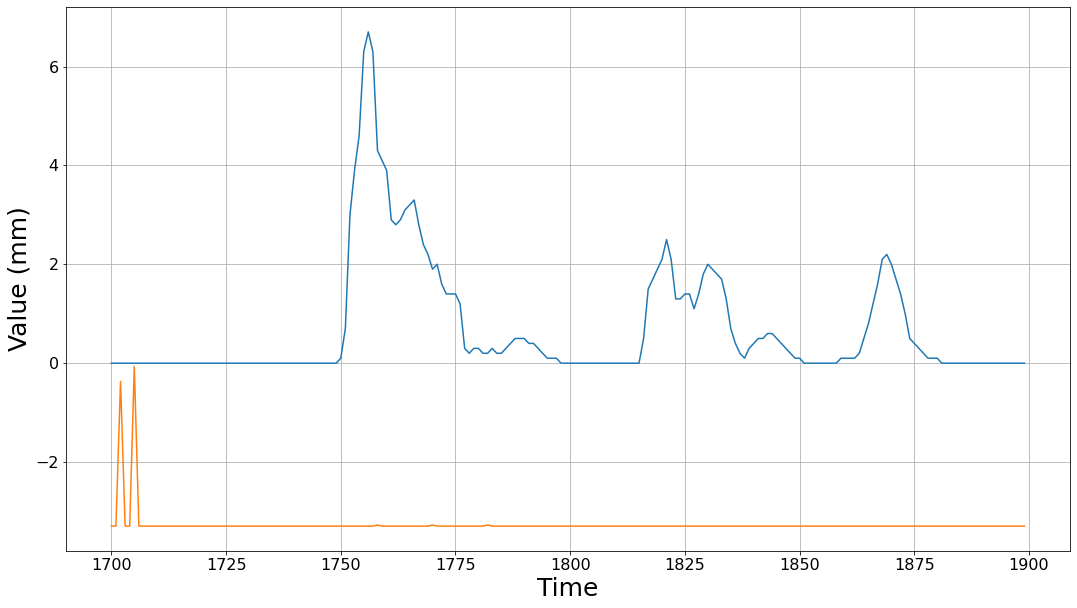

In [ ]:
plt.figure(figsize=(18,10))
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=1700
end=1900

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end])
plot_series((time), prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_24_inputs_one_step_out_2Dcnn_prediction_zoom1.pdf', format='pdf')

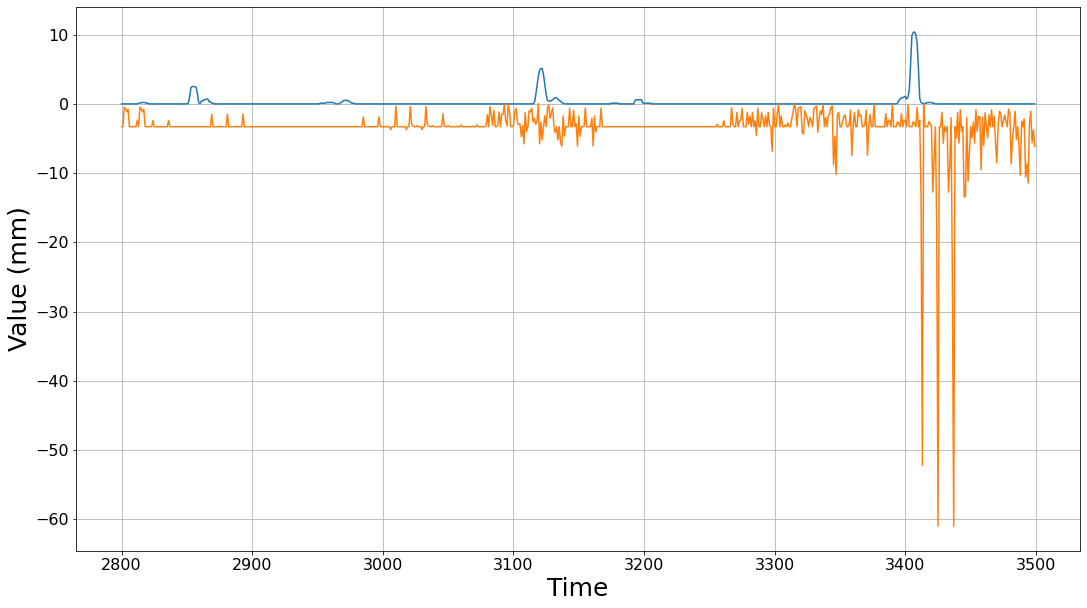

In [ ]:
plt.figure(figsize=(18,10))
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=2800
end=3500

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end])
plot_series((time), prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_24_inputs_one_step_out_2Dcnn_prediction_zoom2.pdf', format='pdf')

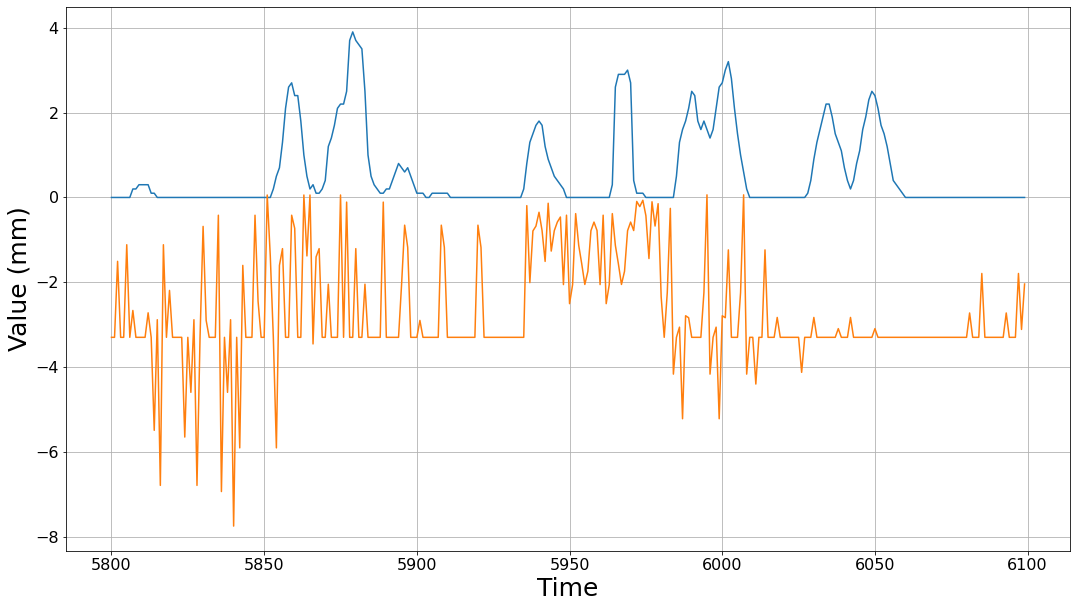

In [ ]:
plt.figure(figsize=(18,10))
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=5800
end=6100

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end])
plot_series((time), prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_24_inputs_one_step_out_2Dcnn_prediction_zoom3.pdf', format='pdf')

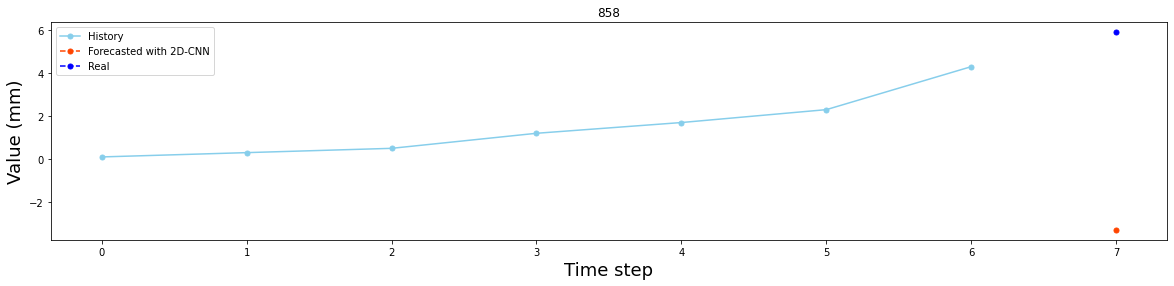

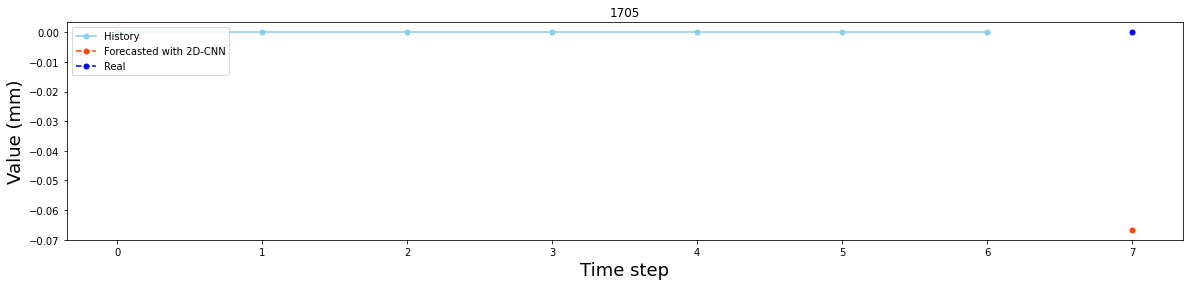

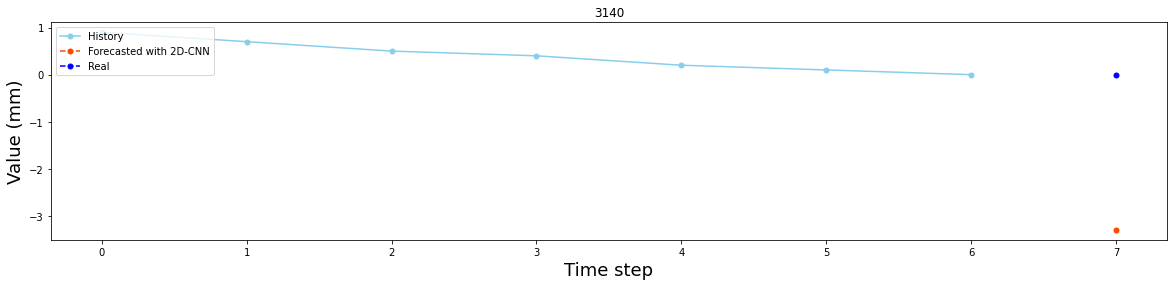

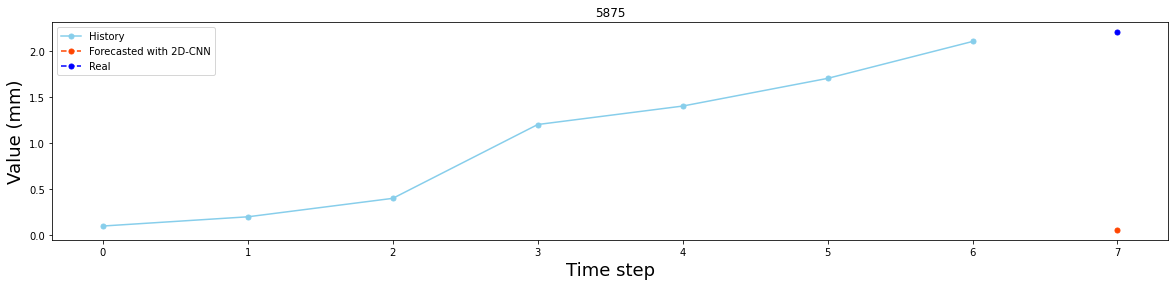

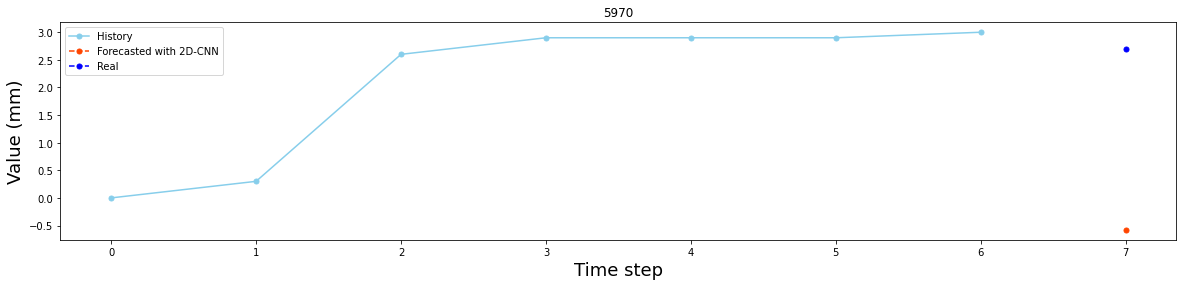

In [ ]:
arr=  [858,1705,3140,5875, 5970]
for i in arr:#range(1700,1720,2):#range(1700,1900,25):
  one_val = np.reshape(X_test[i],(1,3,12, 11, 1) )
  one_val_pred = model.predict(one_val)
  one_val_pred = np.ravel(one_val_pred)
  prev_val = []
  
  for j in range(-7,0):
    prev_val.append(Y_test[i+j])
  
  plot_multistep(prev_val, one_val_pred , Y_test[i] )
  plt.title(str(i))

In [ ]:
"""sns.set_style('darkgrid')

yy = prev_val
yy.append(one_val_pred[0])
xx = list(range(len(yy)))
#xx = ['val ='+str(+i) for i in np.round(yy, decimals=1)]
sns.barplot(xx,yy)

#ax = sns.barplot(x=xx, y=yy, palette="Blues_d")

plt.show()"""


'sns.set_style(\'darkgrid\')\n\nyy = prev_val\nyy.append(one_val_pred[0])\nxx = list(range(len(yy)))\n#xx = [\'val =\'+str(+i) for i in np.round(yy, decimals=1)]\nsns.barplot(xx,yy)\n\n#ax = sns.barplot(x=xx, y=yy, palette="Blues_d")\n\nplt.show()'